# Colorectal Adenocarcinoma (TCGA, PanCancer Atlas)

This notebook builds on top of 01_colorectal_preliminary.ipynb. Bulk of data exploration and transformation logic is present in that notebook and the same functions have been used out of the box in this notebook

1. Load patient data and sample data. Join the two tables and remove the obvious useless columns from the two tables.
1. Remove the other columns figured out after detailed analysis in the first notebook. After this, all columns of X are ready for model development.
1. Prepare the target column y.
1. Since X and y are ready, pass X,y through popular ML models and assess performance.

In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers import load_config, plot_predicted_vs_actual
from colorectal_adenocarcinoma.data_preprocessor import preprocess_data
import sys
import os
import warnings
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")


In [3]:
configs = load_config(os.path.join("configs", "configs.yaml"))

## 1. Load patient and sample data and remove obvious useless columns

#### 1.1 Reading and exploring data clinical patient file

In [4]:
patientdf = pd.read_csv(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "data_clinical_patient.txt"),
    sep="\t",
    header=4
)
patientdf.head()

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
0,TCGA-3L-AA1B,COAD_CIN,COAD,A94E1279-A975-480A-93E9-7B1FF05CBCBF,61.0,Female,STAGE I,7TH,475.0,-22379.0,...,Yes,0:LIVING,15.616267,0:ALIVE OR DEAD TUMOR FREE,15.616267,0:DiseaseFree,15.616267,0:CENSORED,15.616267,AFR_ADMIX
1,TCGA-4N-A93T,COAD_CIN,COAD,92554413-9EBC-4354-8E1B-9682F3A031D9,67.0,Male,STAGE IIIB,7TH,146.0,-24523.0,...,Yes,0:LIVING,4.799947,0:ALIVE OR DEAD TUMOR FREE,4.799947,NaN,NaN,0:CENSORED,4.799947,AFR
2,TCGA-4T-AA8H,COAD_CIN,COAD,A5E14ADD-1552-4606-9FFE-3A03BCF76640,42.0,Female,STAGE IIA,7TH,385.0,-15494.0,...,Yes,0:LIVING,12.657396,0:ALIVE OR DEAD TUMOR FREE,12.657396,0:DiseaseFree,12.657396,0:CENSORED,12.657396,AFR_ADMIX
3,TCGA-5M-AAT4,COAD_CIN,COAD,1136DD50-242A-4659-AAD4-C53F9E759BB3,74.0,Male,STAGE IV,6TH,NaN,-27095.0,...,Yes,1:DECEASED,1.610941,1:DEAD WITH TUMOR,1.610941,NaN,NaN,1:PROGRESSION,1.610941,AFR
4,TCGA-5M-AAT6,COAD_MSI,COAD,CE00896A-F7D2-4123-BB95-24CB6E53FC32,40.0,Female,STAGE IV,6TH,NaN,-14852.0,...,Yes,1:DECEASED,9.534142,1:DEAD WITH TUMOR,9.534142,NaN,NaN,1:PROGRESSION,7.199921,AFR


In [5]:
columns_being_discarded =  [
    # 'SUBTYPE', # consider for later analysis
    'CANCER_TYPE_ACRONYM', # same value for all records
    'OTHER_PATIENT_ID', # id column not related to any data of our interest
    'AJCC_STAGING_EDITION', # version of handbook used for classification
    'DAYS_LAST_FOLLOWUP', # similar but more relevant information captured in OS_Months
    'DAYS_TO_BIRTH', # age captures similar information 
    'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', # similar but more relevant information captured in OS_Months 
    'ETHNICITY', # race column has more rich data
    'FORM_COMPLETION_DATE', # irrelevant to analysis
    'HISTORY_NEOADJUVANT_TRTYN', # highly skewed, 590 No, 2 Yes, 2 Null
    'ICD_O_3_HISTOLOGY' , # which edition of certain code used for tabulating data
    'ICD_O_3_SITE', # which edition of certain code used for tabulating data
    'INFORMED_CONSENT_VERIFIED', # irrelevant to analysis
    'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', # highly skewed 557 Yes, 19 No, 18 Null
    'IN_PANCANPATHWAYS_FREEZE', # if patient is part of a certain analysis, irrelevant
    ]

In [6]:
patientdf_1 = patientdf.drop(columns=columns_being_discarded)
patientdf_1.shape

(594, 24)

#### 1.2 Reading and exploring data clinical sample 

In [7]:
sampledf = pd.read_csv(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "data_clinical_sample.txt"),
    sep="\t",
    header=4
)
sampledf.head()

,PATIENT_ID,SAMPLE_ID,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,TUMOR_TISSUE_SITE,ANEUPLOIDY_SCORE,SAMPLE_TYPE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,SOMATIC_STATUS,TMB_NONSYNONYMOUS,TISSUE_SOURCE_SITE
0,TCGA-AF-2687,TCGA-AF-2687-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,24.0,Primary,0.3529,0.08,Matched,3.266667,Albert Einstein Medical Center
1,TCGA-AF-2689,TCGA-AF-2689-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,18.0,Primary,0.3486,1.28,Matched,1.733333,Mary Bird Perkins Cancer Center - Our Lady of ...
2,TCGA-AF-2690,TCGA-AF-2690-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,25.0,Primary,0.3412,0.03,Matched,2.366667,Duke University
3,TCGA-AF-2691,TCGA-AF-2691-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectal Adenocarcinoma,NaN,Yes,No,AF,Rectum,11.0,Primary,0.3267,1.16,Matched,2.233333,University of Sao Paulo
4,TCGA-AF-2692,TCGA-AF-2692-01,READ,Colorectal Cancer,Rectal Adenocarcinoma,Rectum Adenocarcinoma,NaN,Yes,No,AF,NaN,16.0,Primary,0.3259,1.32,Matched,0.733333,University of Sao Paulo


In [8]:
sampledf.shape

(594, 18)

In [9]:
subset_sample = sampledf.head().T

In [10]:
columns_being_discarded_sampledf = [
    'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR', # when sample was collected, before or after
    'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', # when sample was collected, before or after
    'TISSUE_SOURCE_SITE_CODE', # which hospital was the sample collected at
    'TUMOR_TISSUE_SITE', # part of body where sample was collected
    'SAMPLE_TYPE', # has only one value "Primary"
    'TISSUE_SOURCE_SITE' # which hospital was the sample collected at
]

In [11]:
sampledf_1 = sampledf.drop(columns=columns_being_discarded_sampledf)
sampledf_1.shape, patientdf_1.shape

((594, 12), (594, 24))

In [12]:
sampledf_1.shape, patientdf_1.shape

((594, 12), (594, 24))

#### 1.3 Joining patient and sample data 

In [13]:
df = pd.merge(patientdf_1, sampledf_1, on='PATIENT_ID', how='inner')
df.head()

,PATIENT_ID,SUBTYPE,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,ICD_10,NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,...,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,SOMATIC_STATUS,TMB_NONSYNONYMOUS
0,TCGA-3L-AA1B,COAD_CIN,61.0,Female,STAGE I,C18.0,No,M0,N0,T2,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,19.0,0.3057,0.05,Matched,4.033333
1,TCGA-4N-A93T,COAD_CIN,67.0,Male,STAGE IIIB,C18.2,No,M0,N1B,T4A,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,13.0,0.3317,0.69,Matched,2.900000
2,TCGA-4T-AA8H,COAD_CIN,42.0,Female,STAGE IIA,C18.6,No,MX,N0,T3,...,MACR,Colorectal Cancer,Mucinous Adenocarcinoma of the Colon and Rectum,"Colon Adenocarcinoma, Mucinous Type",NaN,18.0,0.3144,0.17,Matched,4.000000
3,TCGA-5M-AAT4,COAD_CIN,74.0,Male,STAGE IV,C18.2,No,M1B,N0,T3,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,18.0,0.3232,0.55,Matched,5.833333
4,TCGA-5M-AAT6,COAD_MSI,40.0,Female,STAGE IV,C18.2,Yes,M1A,N2B,T4A,...,COAD,Colorectal Cancer,Colon Adenocarcinoma,Colon Adenocarcinoma,NaN,3.0,0.6600,20.58,Matched,62.166667


In [14]:
df.to_excel(
    os.path.join(configs["STORAGE_DIR_STUDY2"], "user_friendly_formats", "raw_patient_sample_merge.xlsx")
)

## 2. Detailed Analysis of Columns left to construct X

#### 2.1 Apply data transformations

##### Data Specifications for the pipeline:
1. GENETIC_ANCESTRY_LABEL: 
    - has values like [' ', 'AFR', 'AFR_ADMIX', 'EAS', 'EUR', 'EUR_ADMIX']
    - highly skewed toward EUR. 
    - output 1 for EUR(white), 0 for non-EUR(non-white).
    - potentially modify later to include other races if good number of records are available.

1. PRIOR_DX
    - starts with either Yes or No. 

1. PATH_M_STAGE
    - contains values out of [M0, M1, M1A, M1B, MX]

1. PATH_T_STAGE
    - contains values out of ['T1', 'T2', 'T3', 'T4', 'T4A', 'T4B', 'TIS']

1. PATH_N_STAGE
    - contains values out of ['N0', 'N1', 'N1A', 'N1B', 'N1C', 'N2', 'N2A', 'N2B'] 

1. All other columns are either object type or int64 type.




In [15]:
columns_to_drop = [
    'GRADE',
    'DFS_MONTHS', 'DFS_STATUS',
    'SUBTYPE', 'ICD_10',
    'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
    'DSS_STATUS', 'DSS_MONTHS',
    'AJCC_PATHOLOGIC_TUMOR_STAGE',
    'SOMATIC_STATUS',
    'TUMOR_TYPE',
    'CANCER_TYPE',
    'RACE',
    'CANCER_TYPE_DETAILED', 
    "OS_STATUS", "OS_MONTHS"
]

df = df.drop(columns=columns_to_drop)

In [16]:
df1 = df.dropna()
df.shape, df1.shape

((594, 19), (243, 19))

In [17]:
df1 = df1[df1["PFS_STATUS"] == "1:PROGRESSION"]
df1.drop(["PFS_STATUS"], axis=1, inplace=True)
df1.shape

(63, 18)

In [18]:
df1

,PATIENT_ID,AGE,SEX,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIOR_DX,RADIATION_THERAPY,WEIGHT,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,SAMPLE_ID,ONCOTREE_CODE,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS
4,TCGA-5M-AAT6,40.0,Female,M1A,N2B,T4A,With Tumor,No,No,99.1,7.199921,AFR,TCGA-5M-AAT6-01,COAD,3.0,0.6600,20.58,62.166667
5,TCGA-5M-AATE,76.0,Male,M0,N0,T3,With Tumor,No,No,75.4,26.629845,,TCGA-5M-AATE-01,COAD,20.0,0.3252,0.47,3.800000
6,TCGA-A6-2671,85.0,Male,M1,N2,T3,With Tumor,No,No,67.2,17.588848,EUR,TCGA-A6-2671-01,COAD,25.0,0.3500,0.37,4.066667
8,TCGA-A6-2674,71.0,Male,M1,N2,T3,Tumor Free,No,No,85.6,24.164119,EUR,TCGA-A6-2674-01,MACR,24.0,0.4577,0.02,7.666667
15,TCGA-A6-2681,73.0,Female,M0,N0,T3,Tumor Free,Yes,No,79.6,37.807805,EUR,TCGA-A6-2681-01,COAD,13.0,0.3456,0.13,8.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,TCGA-AH-6643,50.0,Male,M0,N2B,T3,Tumor Free,No,No,84.4,33.731137,,TCGA-AH-6643-01,READ,19.0,0.3494,0.57,3.333333
567,TCGA-EI-6509,53.0,Male,M0,N2B,T3,Tumor Free,No,No,82.0,2.958872,EUR,TCGA-EI-6509-01,READ,8.0,0.3555,0.50,1.733333
577,TCGA-EI-6885,57.0,Female,M1,N1B,T3,With Tumor,No,No,53.0,9.698524,EUR,TCGA-EI-6885-01,READ,28.0,0.3401,0.11,3.166667
583,TCGA-F5-6571,62.0,Female,M0,N0,T3,Tumor Free,No,No,80.0,4.010915,EUR,TCGA-F5-6571-01,READ,11.0,0.3388,0.35,2.766667


In [19]:
# END #########

In [20]:
df1.to_csv(
    os.path.join(configs['STORAGE_DIR_STUDY2'], 'pathological_df.csv'), index=False)

In [20]:
df2 = df1.drop(["PATIENT_ID", "SAMPLE_ID"], axis=1)
X = df2.drop(["PFS_MONTHS"], axis=1)
y = df2.PFS_MONTHS

In [21]:
X = preprocess_data(X)
X.head()

Label encoded PATH_M_STAGE
Label encoded PATH_N_STAGE
Label encoded PATH_T_STAGE


,AGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,WEIGHT,GENETIC_ANCESTRY_LABEL,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,SEX_Male,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIOR_DX_Y,RADIATION_THERAPY_Yes,ONCOTREE_CODE_MACR,ONCOTREE_CODE_READ
4,40.0,1.0,2.5,4.0,99.1,0,3.0,0.6600,20.58,62.166667,0,1,0,0,0,0
5,76.0,0.0,0.0,3.0,75.4,0,20.0,0.3252,0.47,3.800000,1,1,0,0,0,0
6,85.0,1.0,2.0,3.0,67.2,1,25.0,0.3500,0.37,4.066667,1,1,0,0,0,0
8,71.0,1.0,2.0,3.0,85.6,1,24.0,0.4577,0.02,7.666667,1,0,0,0,1,0
15,73.0,0.0,0.0,3.0,79.6,1,13.0,0.3456,0.13,8.666667,0,0,1,0,0,0


## 3. Preparing X and y for regression 

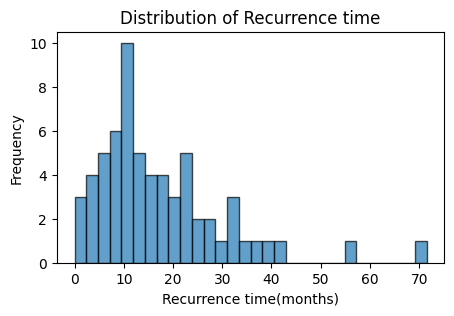

In [22]:
# Plot the distribution
plt.figure(figsize=(5, 3))
plt.hist(df1['PFS_MONTHS'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Recurrence time')
plt.xlabel('Recurrence time(months)')
plt.ylabel('Frequency')

# Display the plot
plt.show()


## 4. Run X, y thru the models

#### 4.1 Define function that takes X and y as input, then standardizes X and passes thru the models

In [50]:
X.shape

(63, 16)

In [49]:
X.head()

,AGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,WEIGHT,GENETIC_ANCESTRY_LABEL,ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,SEX_Male,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIOR_DX_Y,RADIATION_THERAPY_Yes,ONCOTREE_CODE_MACR,ONCOTREE_CODE_READ
4,40.0,1.0,2.5,4.0,99.1,0,3.0,0.6600,20.58,62.166667,0,1,0,0,0,0
5,76.0,0.0,0.0,3.0,75.4,0,20.0,0.3252,0.47,3.800000,1,1,0,0,0,0
6,85.0,1.0,2.0,3.0,67.2,1,25.0,0.3500,0.37,4.066667,1,1,0,0,0,0
8,71.0,1.0,2.0,3.0,85.6,1,24.0,0.4577,0.02,7.666667,1,0,0,0,1,0
15,73.0,0.0,0.0,3.0,79.6,1,13.0,0.3456,0.13,8.666667,0,0,1,0,0,0


In [35]:
def run_regression_models(X, y, n_splits=5):
    """
    Perform multiclass classification using k-fold cross-validation.
    
    Parameters:
        X (numpy.ndarray): Input features.
        y (numpy.ndarray): Target labels.
        n_splits (int): Number of splits for k-fold cross-validation.
        
    Returns:
        dict: Dictionary containing accuracy and recall scores for each model.
    """
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Decision Tree Regression': DecisionTreeRegressor(),
        'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=n_splits, random_state=55, shuffle=True)
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Initialize dictionary to store results
    predictions = {}
    
    # Perform k-fold cross-validation for each model
    for name, model in models.items():
        all_y, all_y_pred = [], []
        
        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Standardize the data
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train the model
            model.fit(X_train_scaled, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test_scaled)

            all_y += y_test.tolist()
            all_y_pred += y_pred.tolist()

        rmse = mean_squared_error(all_y, all_y_pred, squared=False)
        r2 = r2_score(all_y, all_y_pred)
        predictions[name] = {
            "y": all_y, 
            "y_pred": all_y_pred,
            "rmse": rmse,  
            "r2": r2
            }
        print(f"{model} - RMSE: {rmse:.4f}, R2: {r2*100:.4f}%")
    return predictions


#### 4.2 Run data through the models

In [36]:
predictions = run_regression_models(X, y)

LinearRegression() - RMSE: 15.6638, R2: -43.6753%
Ridge() - RMSE: 15.7240, R2: -44.7825%
Lasso() - RMSE: 14.0631, R2: -15.8119%
DecisionTreeRegressor() - RMSE: 21.5631, R2: -172.2775%
RandomForestRegressor(random_state=42) - RMSE: 15.1913, R2: -35.1393%
GradientBoostingRegressor(random_state=42) - RMSE: 18.7927, R2: -106.8091%
SVR() - RMSE: 14.0523, R2: -15.6338%


In [37]:
def show_results(predictions_og:dict):
    """Function to use output of run_regression_models and return dataframe of results"""
    predictions = copy.deepcopy(predictions_og)
    keys_to_remove = ['y', 'y_pred']

    # Iterate over each item in the outer dictionary
    for outer_key, inner_dict in predictions.items():
        # Remove specified keys from the inner dictionary
        for key in keys_to_remove:
            if key in inner_dict:
                del inner_dict[key]
    return pd.DataFrame(predictions)


In [38]:
show_results(predictions)

,Linear Regression,Ridge Regression,Lasso Regression,Decision Tree Regression,Random Forest Regression,Gradient Boosting Regression,Support Vector Regressor
rmse,15.663765,15.724004,14.063122,21.563094,15.191335,18.792734,14.052308
r2,-0.436753,-0.447825,-0.158119,-1.722775,-0.351393,-1.068091,-0.156338


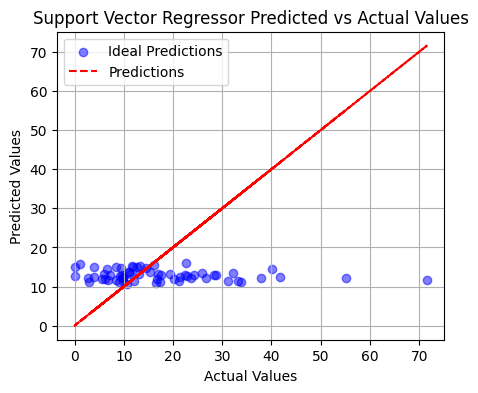

In [43]:
plot_predicted_vs_actual(predictions, visualize_model="Support Vector Regressor")

#### 4.3 Create function to plot feature importance plot

In [46]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_feature_importance_plot_using_rf(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize Random Forest classifier
    rf_classifier = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the classifier
    rf_classifier.fit(X_scaled, y)

    # Get feature importances
    feature_importances = rf_classifier.feature_importances_

    # Get feature names
    feature_names = X.columns  # Replace with actual feature names if available

    # Create feature importance plot
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, feature_importances)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance Plot')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


#### 4.4 Plot feature importance plot

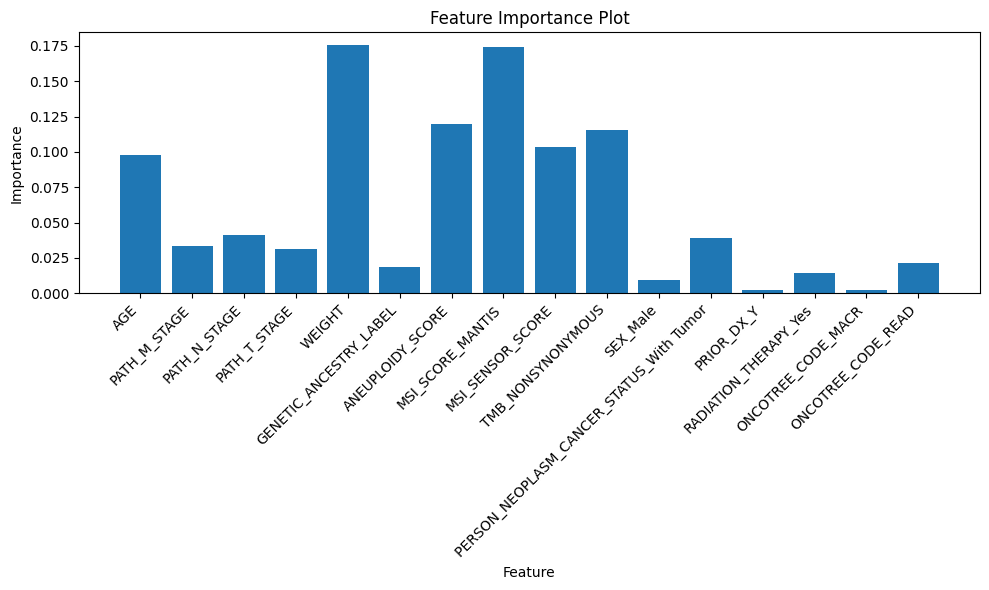

In [47]:
plot_feature_importance_plot_using_rf(X, y)